In [5]:
import numpy as np
import scipy
from scipy.io import wavfile
from numpy.fft import fft, ifft, fftshift
import librosa as lb
from scipy.signal import hann
import matplotlib.pyplot as plt 
import sounddevice
from IPython.display import Audio 
from IPython.core.display import display

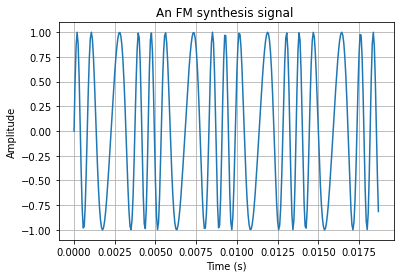

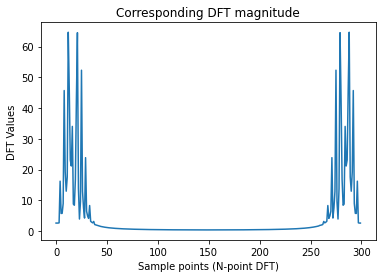

In [8]:
# Problem 1: Frequency modulation (FM) sound synthesis
fs = 16000  # Sampling rate: 16000 Hz 
fc = 880    # Carrier frequency: 880 Hz
fm = 220  # modulation frequency fm=220 Hz!
A=1         # Amplitude: 1
I =2        # Modulation index: 2
duration = 1      # Signal duration: 1 s

t=np.linspace(0,duration,fs*duration)
y = A*np.sin(2*np.pi*fc*t+I*np.sin(2*np.pi*fm*t))

# Now plot the signal and its DFT spectrum
plt.plot(t[:300],y[:300])
plt.xlabel('Time (s)') # x-axis label
plt.ylabel('Amplitude') # y-axis label
plt.title('An FM synthesis signal ')
plt.grid(True, 'both')
plt.show()
display(Audio(y, rate=fs))
# Now plot its DFT spectrum
DFT=np.abs(fft(y[:300]))
plt.plot(DFT)
plt.title('Corresponding DFT magnitude')
plt.xlabel('Sample points (N-point DFT)')
plt.ylabel('DFT Values')    

plt.show()

In [10]:
def princarg(phase_in):
  """
  Computes principle argument,  wraps phase to (-pi, pi]
  """
  phase = np.mod(phase_in + np.pi,-2*np.pi)+np.pi
  return phase

def delta_phi_(Phase_current, Phase_previous, winHopAn, wLen):
    """
    Function for calculating unwrapped phase difference between consecutive frames
    
    Phase_current: current frame phase
    Phase_previous: previous frame phase
    winHopAn: Analysis hop length
    wLen: window length
    """
    
    # nominal phase increment for the analysis hop size for each bin
    omega = 2*np.pi*(winHopAn/wLen)*np.arange(0, wLen)
    delta_phi = omega + princarg(Phase_current-Phase_previous-omega)
    
    return delta_phi

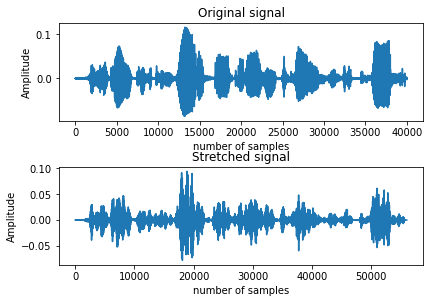

In [12]:
# A Loop for overap add reconstruction  with no spectral processing in between    
audioIn, fs=lb.load('/content/audio.wav', sr=None)   # read audio
audioOut = np.zeros(int(len(audioIn)*R))      # placeholder for reconstructed audio
wLen = int(0.032*fs)                   # window length
winAn = np.sqrt(hann(wLen, sym=False)) # analysis window
winSyn =winAn
winHopAn = int(0.008*fs)             # Hop length or frame advance
inInd = 0
synInd = 0
winHopSyn = int(0.008*fs) 
R=1.4
Phase_previous=0
Phase_previous_S=0

while inInd< len(audioIn)-wLen:

  # selct the frame and multiply with window function
  frame = audioIn[inInd:inInd+wLen]* winAn 
  # compute DFT
  f = fft(frame)
   
  # save magnitudes and phases
  mag_f = np.abs(f)          # Mag(t) 
  phi0 = np.angle(f)         # Phase(t) 
  
  ####################
  # processing in spectral domain
  Phase_current = phi0
  delta_phi=delta_phi_(Phase_current, Phase_previous, winHopAn, wLen)

  Phase_previous=Phase_current
  synth_phase = Phase_previous_S+R* delta_phi
  ## 4. 
  # We need to scale delta_phi here because The phase of the Fourier spectra of frames that are X samples apart will differ by an amount that is different from
  # the phase of Fourier spectra of frames that are Y samples apart.
  # Therefore, if the original hop size was X samples, and it was adjusted to Y samples, scale DeltaPhase by Y/X
  # This adjusts the phase difference between adjacent frames to what it must be for the modified hop size


  phi0 =  princarg(synth_phase)
  Phase_previous_S= phi0

  #######################

  # Recover the complex FFT back
  ft = (abs(f)* np.exp(1j*phi0))  

  # inverse DFT and windowing
  frame = np.real(ifft(ft))*winSyn
   
  # Ovelap add
 
  audioOut[synInd :synInd +wLen] =  audioOut[synInd :synInd +wLen] + frame
  # frame advance by winHopAn
  inInd = inInd + winHopAn
  synInd = synInd + int(winHopAn*R)

display(Audio(audioIn, rate=fs))
display(Audio(audioOut, rate=fs))

#  Plot original signal
plt.subplot(2,1,1)
plt.plot(audioIn[int(0.0*fs):int(5*fs)])
# label the axes
plt.ylabel("Amplitude")
plt.xlabel("number of samples")
# set the title  
plt.title("Original signal")
plt.tight_layout(pad = 1.5)
#  Plot stretched signal in same plot
plt.subplot(2,1,2)
plt.plot(audioOut[int(0.0*fs):int(5*fs)])
# label the axes
plt.ylabel("Amplitude")
plt.xlabel("number of samples")
# set the title  
plt.title("Stretched signal")

# display the plot
plt.show()
